# Explain different DL models for Sleep Staging with Spectral Gradients

In [1]:
from utils import set_root

from loguru import logger

import numpy as np
import torch

from tqdm import tqdm

from captum.attr import IntegratedGradients

from pytorch_lightning import seed_everything

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal
import pandas as pd

seed_everything(42)
set_root()

Seed set to 42


Current working directory: /home/guido/github/dev/physioex-private


In [2]:
from physioex.data import TimeDistributedModule, SleepEDF, Shhs

from physioex.train.networks import config as networks
from physioex.train.networks.utils.loss import config as losses

from physioex.models import load_pretrained_model

from physioex.explain.spectralgradients import (
    SpectralGradients,
    generate_frequency_bands,
    plot,
)

from physioex.explain.spectralgradients.viz import plot_class_spectrum

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
/home/guido/miniconda3/envs/physioex/lib/python3.10/site-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


In [3]:
# model parameters
model_name = "chambon2018"
sequence_length = 21

# dataset
picks = ["EEG"]
fold = 0

# dataloader
batch_size = 512
num_workers = 4

# num of splitting bands
n_bands = 20

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# load dataset and model
model = networks[model_name]

dataset = Shhs(
    picks=picks,
    sequence_length=sequence_length,
    target_transform=model["target_transform"],
    preprocessing=model["input_transform"],
)

dataset.split(fold=fold)

dataset = TimeDistributedModule(
    dataset=dataset, batch_size=batch_size, fold=fold, num_workers=num_workers
)

model = load_pretrained_model(
    name=model_name,
    in_channels=len(picks),
    sequence_length=sequence_length,
    softmax=True,
).eval()

# setup the explanations algorithms
sg = SpectralGradients(model, n_bands=n_bands)

/home/guido/github/dev/physioex-private/physioex/models/load.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ckpt_path = ckpt_path[ check_table["sequence_length"] == sequence_length ]
/home/guido/github/dev/physioex-private/physioex/models/load.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ckpt_path = ckpt_path[ check_table["in_channels"] == in_channels ]
/home/guido/github/dev/physioex-private/physioex/models/load.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ckpt_path = ckpt_path[ check_table["loss"] == loss ]
2024-05-25 20:52:14.981 | INFO     | physioex.models.load:load_pretrained_model:67 - Sequential(
  (0): Chambon2018Net(
    (nn): Net(
      (epoch_encoder): SleepStagerChambon2018(
        (feature_extractor): Sequential(
          (0): Conv2d(1, 8, kernel_size=(1, 50), stride=(1, 1), padding=(0, 25))
          (1): Identity()
          (2): ReLU()
          (3): 

1
Frequency bands: [[0.1, 2.45], [2.45, 4.9], [4.9, 7.35], [7.35, 9.8], [9.8, 12.25], [12.25, 14.7], [14.7, 17.15], [17.15, 19.6], [19.6, 22.05], [22.05, 24.5], [24.5, 26.95], [26.95, 29.4], [29.4, 31.85], [31.85, 34.3], [34.3, 36.75], [36.75, 39.2], [39.2, 41.65], [41.65, 44.1], [44.1, 46.55], [46.55, 49.0]]


In [5]:
plot_class_spectrum(
    dataloader=dataset.train_dataloader(),
    model=model,
    sg=sg,
    n_classes=5,
    classes={0: "Wake", 1: "N1", 2: "N2", 3: "N3", 4: "REM"},
    relevant_bands={
        "Wake": ["Beta", "Gamma"],
        "N1": ["Alpha", "Theta"],
        "N2": ["Theta", "Delta"],
        "N3": ["Delta"],
        "REM": ["Alpha", "Beta"],
    },
    band_colors={
        "Delta": "blue",
        "Theta": "green",
        "Alpha": "red",
        "Sigma": "purple",
        "Beta": "orange",
        "Gamma": "brown",
    },
    eeg_bands={
        "Delta": (0, 4),
        "Theta": (4, 8),
        "Alpha": (8, 12),
        "Sigma": (12, 16),
        "Beta": (16, 30),
        "Gamma": (30, 50),
    },
    filename=f"results/{model_name}/class_spectrum.png",
)

0it [00:00, ?it/s]/home/guido/miniconda3/envs/physioex/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/guido/github/dev/physioex-private/physioex/explain/spectralgradients/viz.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  spectral_importances[y_preds[i]] = spectral_importances[y_preds[i]].append(new_row, ignore_index=True)
1288it [23:46:06, 65.15s/it]

In [ ]:
spectral_importances[0].shape

(10398, 20)

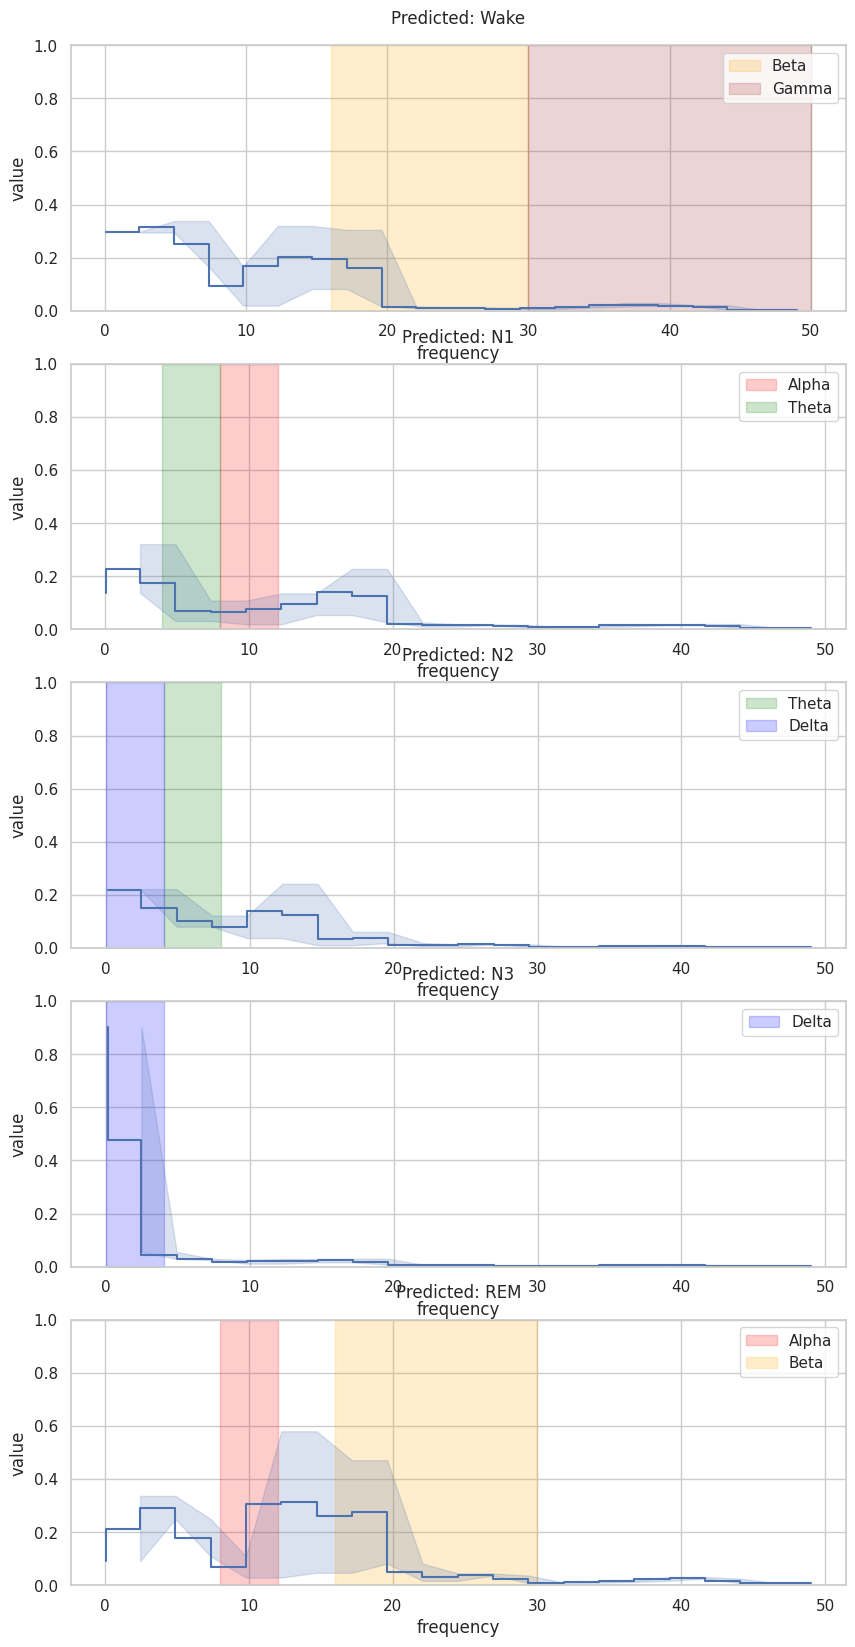

In [ ]:
fig, ax = plt.subplots(5, 1, figsize=(10, 20))

# Mappa gli indici alle fasi del sonno
sleep_stages = {0: "Wake", 1: "N1", 2: "N2", 3: "N3", 4: "REM"}

# Mappa ogni fase del sonno alle sue bande di frequenza rilevanti
relevant_bands = {
    "Wake": ["Beta", "Gamma"],
    "N1": ["Alpha", "Theta"],
    "N2": ["Theta", "Delta"],
    "N3": ["Delta"],
    "REM": ["Alpha", "Beta"],
}

# Definisci le bande di frequenza dell'EEG
eeg_bands = {
    "Delta": (0, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Sigma": (12, 16),
    "Beta": (16, 30),
    "Gamma": (30, 50),
}

# Definisci i colori per ogni banda
band_colors = {
    "Delta": "blue",
    "Theta": "green",
    "Alpha": "red",
    "Sigma": "purple",
    "Beta": "orange",
    "Gamma": "brown",
}

for i in range(5):
    ax[i].set_title(
        f"Predicted: {sleep_stages[i]}", fontsize=12, y=1.05
    )  # Usa il nome della fase del sonno come titolo

    df_new = pd.DataFrame(columns=["frequency", "value"])
    for column in spectral_importances[i].columns:
        start, end = map(float, column.strip("[]").split(", "))
        df_new = pd.concat(
            [
                df_new,
                pd.DataFrame(
                    {
                        "frequency": [start],
                        "value": [spectral_importances[i][column].mean()],
                    }
                ),
            ]
        )
        df_new = pd.concat(
            [
                df_new,
                pd.DataFrame(
                    {
                        "frequency": [end],
                        "value": [spectral_importances[i][column].mean()],
                    }
                ),
            ]
        )

    for band in relevant_bands[
        sleep_stages[i]
    ]:  # Usa solo le bande rilevanti per la fase del sonno corrente
        ax[i].fill_betweenx(
            [0, 1], *eeg_bands[band], color=band_colors[band], alpha=0.2, label=band
        )  # Regola l'opacità con alpha

    # Crea il grafico a linee con l'asse x rappresentante le frequenze e l'asse y rappresentante i valori
    sns.lineplot(x="frequency", y="value", data=df_new, drawstyle="steps-pre", ax=ax[i])

    ax[i].set_ylim([0, 1])
    ax[i].legend()  # Mostra la legenda

In [ ]:
torch.set_printoptions(precision=2)
output = model(inputs.to(device)).detach().cpu()

y = torch.argmax(output, dim=1)

print(f"Predicted: {y[0]}")

baselines = sg._construct_baseline(inputs)
importances = torch.zeros(baselines.shape[-1])

temp = output[0]

for i in range(1, baselines.shape[-1] + 1):
    preds = model(baselines[..., -i].to(device)).detach().cpu()[0]

    importances[-i] = torch.norm(temp[y[0]] - preds[y[0]])

    temp = preds

    print(f"Band {sg.bands[-i]} importance: {importances[-i]:.2f}, output { preds }")


attr = (
    sg.attribute(inputs.to(device), target=torch.argmax(output, dim=1).to(device))
    .detach()
    .cpu()
)[0]

ig_attr = (
    ig.attribute(inputs.to(device), target=torch.argmax(output, dim=1).to(device))
    .detach()
    .cpu()
)[0]

Predicted: 0
Band [46.55, 49.0] importance: 0.00, output tensor([6.67e-01, 2.66e-01, 1.79e-02, 2.61e-06, 4.86e-02])
Band [44.1, 46.55] importance: 0.01, output tensor([6.60e-01, 2.70e-01, 1.84e-02, 2.77e-06, 5.12e-02])
Band [41.65, 44.1] importance: 0.04, output tensor([6.22e-01, 2.92e-01, 2.20e-02, 3.17e-06, 6.40e-02])
Band [39.2, 41.65] importance: 0.04, output tensor([5.80e-01, 3.15e-01, 2.34e-02, 2.17e-06, 8.22e-02])
Band [36.75, 39.2] importance: 0.07, output tensor([5.12e-01, 3.37e-01, 2.99e-02, 2.48e-06, 1.21e-01])
Band [34.3, 36.75] importance: 0.00, output tensor([5.14e-01, 3.43e-01, 2.63e-02, 1.68e-06, 1.17e-01])
Band [31.85, 34.3] importance: 0.01, output tensor([5.00e-01, 3.49e-01, 2.66e-02, 1.50e-06, 1.25e-01])
Band [29.4, 31.85] importance: 0.01, output tensor([4.90e-01, 3.44e-01, 2.83e-02, 1.47e-06, 1.38e-01])
Band [26.95, 29.4] importance: 0.03, output tensor([4.64e-01, 3.43e-01, 3.42e-02, 1.99e-06, 1.58e-01])
Band [24.5, 26.95] importance: 0.03, output tensor([4.93e-01

/home/guido/miniconda3/envs/physioex/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [ ]:
def smooth_importance(heatmap, n=3):
    heatmap = heatmap.clone()

    for i in range(heatmap.shape[0]):

        # start 0, end -n, step n
        for j in range(0, heatmap.shape[1] - n, n):
            # take the sign of the maximum abs value in the window
            max_index = torch.argmax(torch.abs(heatmap[i, j : j + n]))
            max_value = heatmap[i, j : j + n][max_index]

            heatmap[i, j : j + n] = torch.ones(n) * max_value

    return heatmap

Predicted: 0


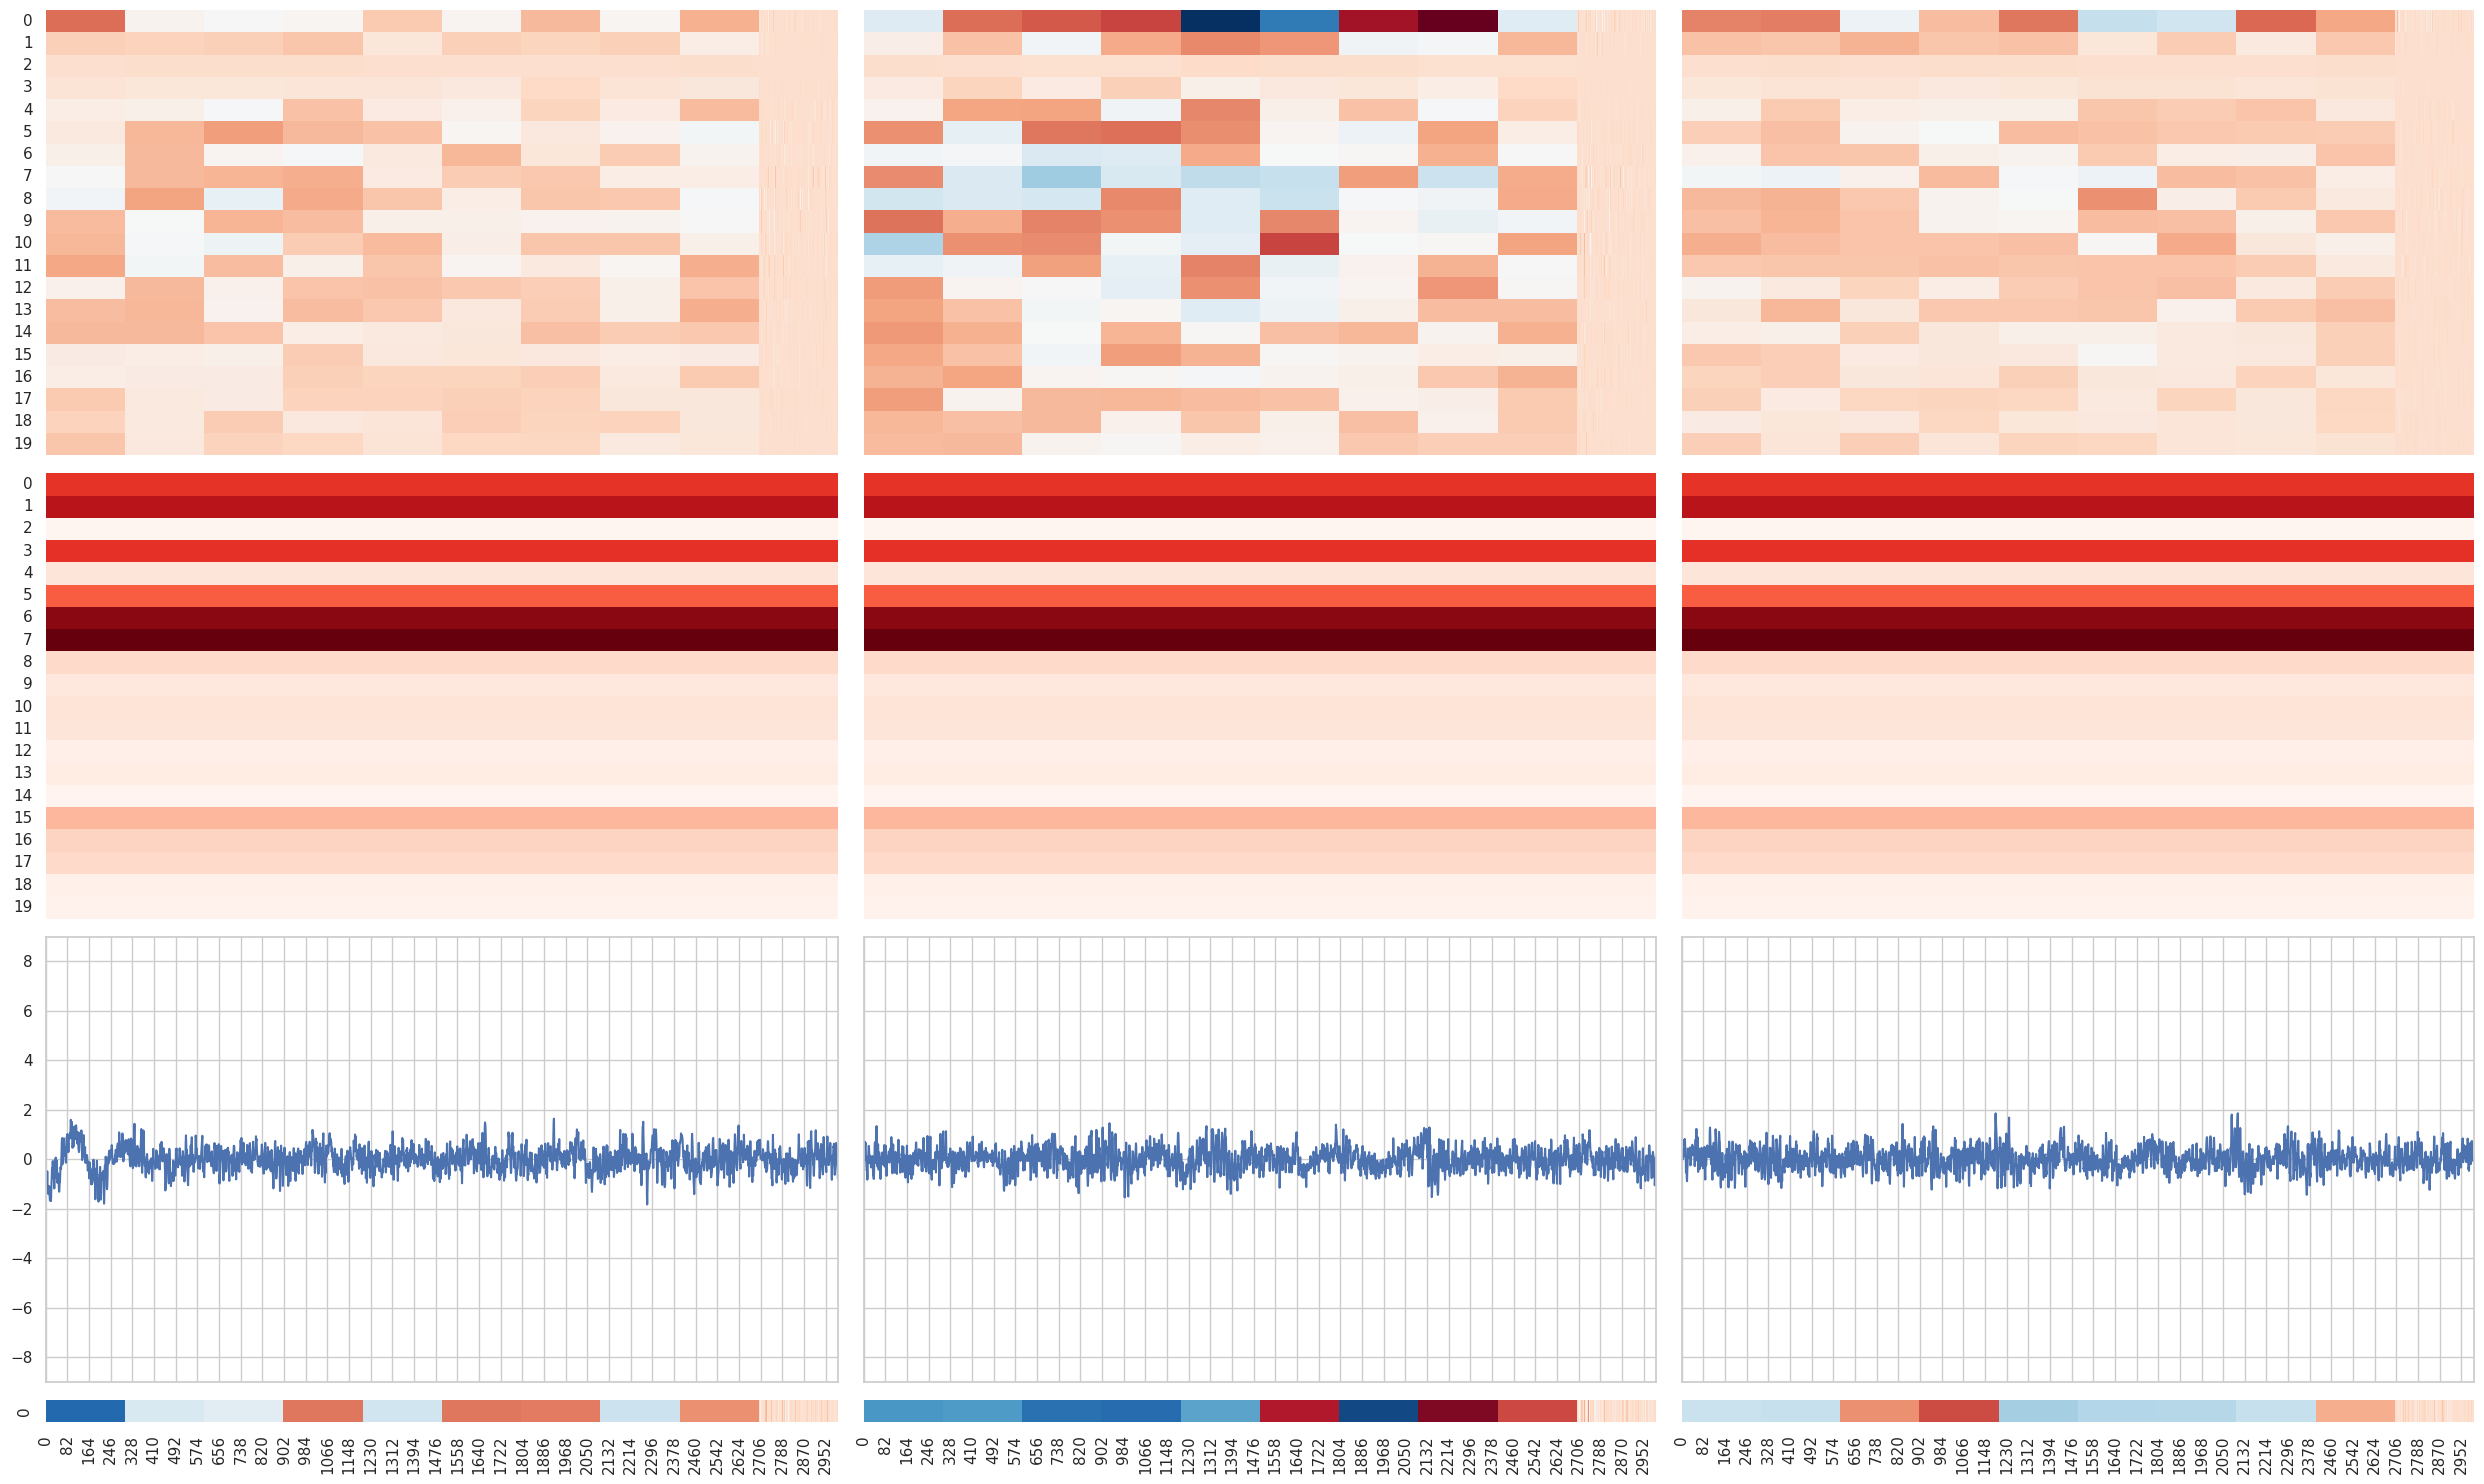

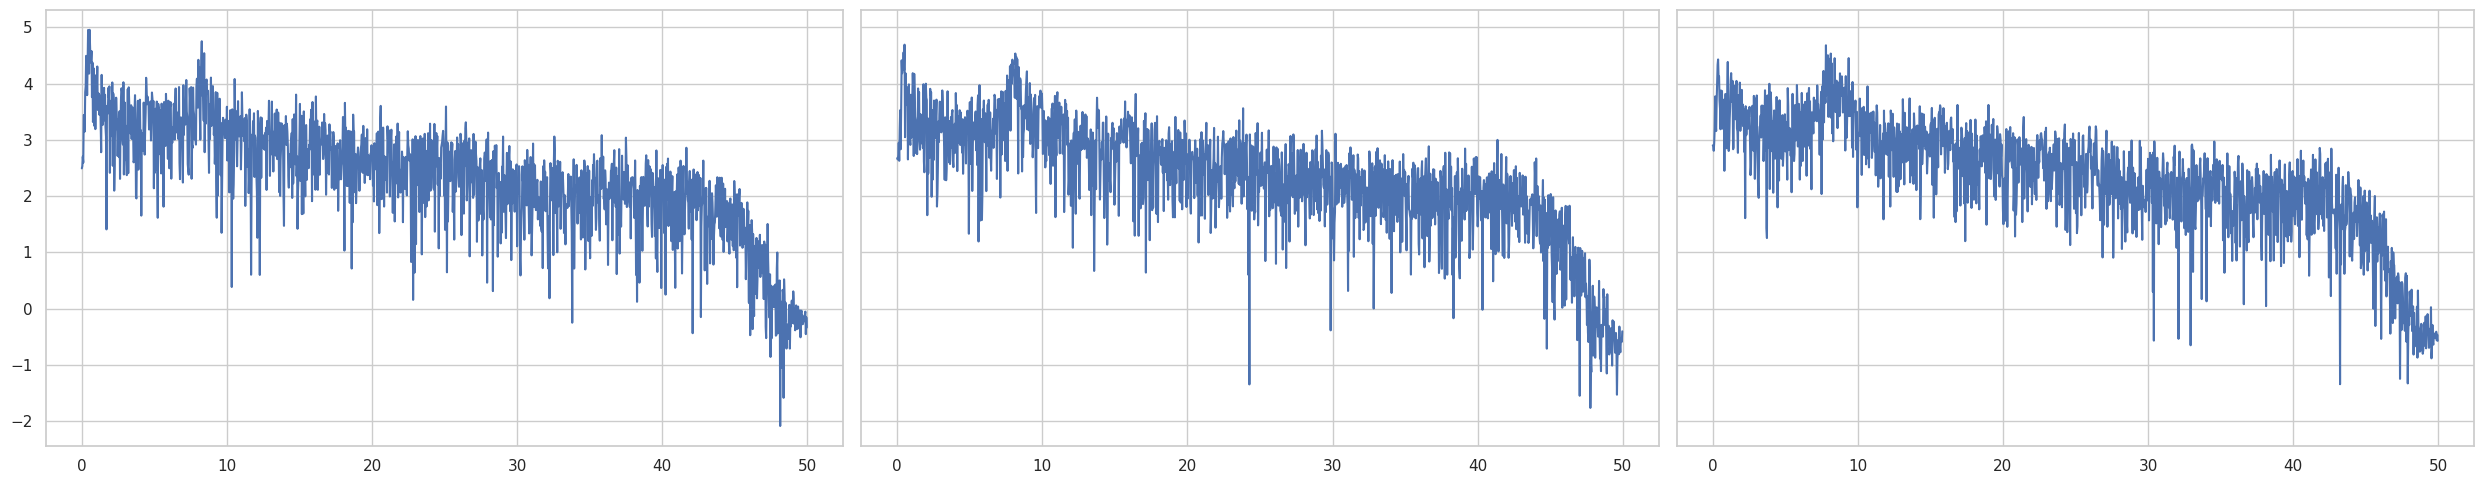

In [ ]:
print(f"Predicted: {y[0]}")

# plotta la serie temporale di input in un subplot per ogni elemento della sequenza
height_ratios = [1, 1, 1, 1 / 20]
fig, axs = plt.subplots(
    4,
    sequence_length,
    figsize=(25, 15),
    sharex="col",
    sharey="row",
    gridspec_kw={"height_ratios": height_ratios},
)

for i in range(sequence_length):
    heat = torch.ones(baselines.shape[-1], inputs.shape[-1])
    attr_heat = smooth_importance(torch.transpose(attr[i].squeeze(), 1, 0), n=300)
    ig_heat = smooth_importance(ig_attr[i].view(1, -1), n=300)

    for b in range(baselines.shape[-1]):
        heat[b] = heat[b] * importances[b]
        # attr_heat[b] = attr_heat[b] * importances[b]

    sns.heatmap(
        attr_heat.numpy(),
        ax=axs[0, i],
        cmap="RdBu",
        vmax=attr.max(),
        vmin=attr.min(),
        cbar=False,
    )

    sns.heatmap(
        heat.numpy(),
        ax=axs[1, i],
        cbar=False,
        cmap="Reds",
    )

    sns.lineplot(inputs[0, i].view(-1).numpy(), ax=axs[2, i])
    axs[2, i].set_ylim((-9, 9))

    sns.heatmap(
        ig_heat.numpy(),
        ax=axs[3, i],
        cmap="RdBu",
        vmax=attr.max(),
        vmin=attr.min(),
        cbar=False,
    )

plt.tight_layout()

# for each element of the sequence, plot the power spectral density of the input signal
fig, axs = plt.subplots(1, sequence_length, figsize=(25, 5), sharex="col", sharey="row")

for i in range(sequence_length):

    # compute the power spectral density
    psd = np.abs(np.fft.fft(inputs[0, i].view(-1).numpy())) ** 2
    freqs = np.fft.fftfreq(inputs.shape[-1], 1 / 100)

    # take only the positive half of the spectrum
    psd = psd[freqs >= 0]
    freqs = freqs[freqs >= 0]

    # double the PSD values to conserve the total power
    psd = 2 * psd
    psd = np.log10(psd)

    # plot the PSD
    sns.lineplot(
        x=freqs,
        y=psd,
        ax=axs[i],
    )

plt.tight_layout()

In [ ]:
print(Sxx.shape)

NameError: name 'Sxx' is not defined

In [ ]:
plot(
    input=inputs[0].detach().cpu(),
    attr=attr[0].detach().cpu(),
    bands=sg.bands,
    figsize=(25, 8),
)

AssertionError: Attr must be a 4D tensor with dimensions: S x C x NS x F

In [ ]:
metric = quantus.Infidelity()

sm = []
for f in range(F):
    spect_metr = metric(
        model,
        inputs.reshape(inputs.size(0), 1, -1).numpy(),
        labels.numpy(),
        device=device,
        explain_func=spect_grad_attr,
        explain_func_kwargs={"filter": f},
    )
    sm.append(spect_metr)


print(f"Spectral gradients metric {spect_metr}")

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 63000]

In [ ]:
sg.bands[i][0]

0.1